In [2]:
import yaml
import netCDF4 as nc
import numpy as np
from utils.read_data import *
from utils.param_alpha import update_alpha_GD, update_alpha_GD_stockes, update_alpha_GD_wind_only
from models.linear_model import u_drift_linear_matrix, u_drift_ocean_only, u_drift_wind_only
from models.stockes_model import u_drift_ocean_wind_stockes_matrix, u_drift_ocean_stockes_matrix,u_drift_stockes_only
from utils.RK4 import RK4_step, compute_position
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from utils.read_data import get_number_hours


ImportError: attempted relative import with no known parent package

In [2]:
'''with open('configs/trace_july2014.yml', 'r') as f:
    config = yaml.safe_load(f)'''

with open('configs_2/trace_ISMER_20140706_spot073_drift.yml', 'r') as f:
    config = yaml.safe_load(f)


pos_1, time1 = get_initial_position(config['PATH_DRIFT']) 

true_lon, true_lat, true_time = get_true_drift_positions(config['PATH_DRIFT'])
nhours = get_number_hours(true_time)

# Get interpolated initial data
u10_interpolation, v10_interpolation = wind_interpolated(config['PATH_WIND'])
water_u_interpolation, water_v_interpolation = water_interpolated(config['PATH_WATER'])
ust_interpolation, vst_interpolation = wave_interpolated(config['PATH_WAVES'])

# GRADIENT DESCENT ALPHA
alpha = update_alpha_GD(config['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation,alpha = 0.02, theta = 0.349066,  step=0.1, npoints=3)
alpha_stockes = update_alpha_GD_stockes(config['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation, ust_interpolation, vst_interpolation, alpha = 0.005, theta = 0.349066,  step=0.2, npoints=3)
alpha_wind_only = update_alpha_GD_wind_only(config['PATH_DRIFT'], u10_interpolation, v10_interpolation,alpha = 0.02, theta = 0.349066,  step=0.1, npoints=3)

# Drift velocity functions
u_drift = u_drift_linear_matrix(alpha, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation)
u_drift_ocean_wind_stockes = u_drift_ocean_wind_stockes_matrix(alpha_stockes, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation, ust_interpolation, vst_interpolation)
u_drift_ocean_stockes = u_drift_ocean_stockes_matrix(water_u_interpolation,water_v_interpolation,ust_interpolation, vst_interpolation)
u_drift_wind = u_drift_wind_only(alpha_wind_only,u10_interpolation, v10_interpolation)
u_drift_ocean = u_drift_ocean_only(water_u_interpolation,water_v_interpolation)
u_drift_stockes = u_drift_stockes_only(ust_interpolation, vst_interpolation)



In [12]:
longitudes, latitudes, _ = compute_position(u_drift, pos_1, time1,1,nhours)
longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes, _ = compute_position(u_drift_ocean_wind_stockes, pos_1, time1,1,nhours)
longitudes_ocean_stockes, latitudes_ocean_stockes, _ = compute_position(u_drift_ocean_stockes, pos_1, time1,1,nhours)
longitudes_wind, latitudes_wind, _ = compute_position(u_drift_wind, pos_1, time1,1,nhours)
longitudes_ocean, latitudes_ocean, _ = compute_position(u_drift_ocean, pos_1, time1,1,nhours)
longitudes_stockes, latitudes_stockes, _ = compute_position(u_drift_stockes, pos_1, time1,1,nhours)

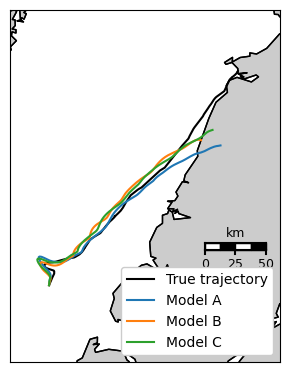

In [43]:
# setting the size of the map
fig = plt.figure(figsize=(3,4))

# creating the map - setting latitude and longitude
#m = Basemap(projection = 'mill', llcrnrlat = 46, urcrnrlat = 50, llcrnrlon = -71, urcrnrlon = -63, resolution = 'i') #august2015
#m = Basemap(projection = 'mill', llcrnrlat = 44, urcrnrlat = 52, llcrnrlon = -74, urcrnrlon = -53, resolution = 'i') 
m = Basemap(projection = 'mill', llcrnrlat = 49, urcrnrlat = 51, llcrnrlon = -59, urcrnrlon = -57, resolution = 'i') #july2014
#m = Basemap(projection = 'mill', llcrnrlat = 46, urcrnrlat = 49, llcrnrlon = -63.5, urcrnrlon = -60, resolution = 'i') #oct2014

# drawing the coastline
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawcoastlines()
m.fillcontinents()


# plotting the map
#m.scatter(lon, lat, latlon = True, s = 10, c = 'red', marker = '.', alpha = 1)
m.plot(true_lon,true_lat,latlon=True,linewidth=1.5,color='k', label='True trajectory')
#m.scatter(true_lon[0],true_lat[0], latlon=True,s=10,color='g',marker ='o',alpha=1)
m.plot(longitudes,latitudes,latlon=True,linewidth=1.5, label=r'Model A')
m.plot(longitudes_ocean_stockes, latitudes_ocean_stockes,latlon=True,linewidth=1.5, label=r'Model B')
m.plot(longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes,latlon=True,linewidth=1.5,label=r'Model C')
#m.plot(longitudes_wind, latitudes_wind,latlon=True,linewidth=1.5,label=r'$\vec{u}_d = \alpha \vec{u}_W$')
#m.plot(longitudes_ocean, latitudes_ocean,latlon=True,linewidth=1.5, label=r'$\vec{u}_d = \vec{u}_O$')
#m.plot(longitudes_stockes, latitudes_stockes,latlon=True,linewidth=1.5, label=r'$\vec{u}_d = \vec{u}_S$')

#plot grid ocean

m.drawmapscale(-57.33, 49.66, -60, 48, 50, barstyle='fancy')

#m.scatter(gridx_wind,gridy_wind,latlon=True,s=10,color='k',marker ='+',alpha=0.5, label='Grid for wind data')

plt.legend(loc = 'lower right',framealpha=1)
plt.tight_layout()
plt.savefig('figures/trace_ABC_example1.png') #, format='eps')

In [5]:
'''with open('configs_2/trace_ISMER_20140706_spot073_drift.yml', 'r') as f:
    config1 = yaml.safe_load(f)

with open('configs_2/trace_ISMER_20141022_spot243_drift.yml', 'r') as f:
    config2 = yaml.safe_load(f)

with open('configs_2/trace_ISMER_20141027_spot215_drift.yml', 'r') as f:
    config3 = yaml.safe_load(f)'''

#====================================NOT WORKIN TRAJECTORIES ==============================================
    
with open('configs_2/trace_ISMER_20150805_spot720_drift.yml', 'r') as f:
    config1 = yaml.safe_load(f)

with open('configs_2/trace_ISMER_20140901_spot013_drift.yml', 'r') as f:
    config2 = yaml.safe_load(f)

with open('configs_2/trace_ISMER_20150809_spot921_drift.yml', 'r') as f:
    config3 = yaml.safe_load(f)

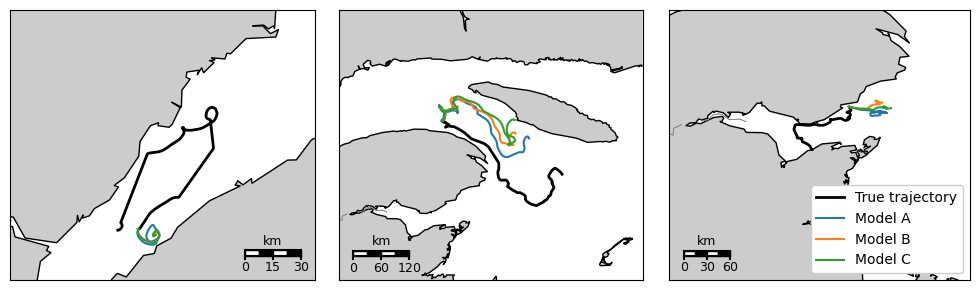

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

#=======================================================================================================================================================================================================================================
pos_1, time1 = get_initial_position(config3['PATH_DRIFT']) 

true_lon, true_lat, true_time = get_true_drift_positions(config3['PATH_DRIFT'])
nhours = get_number_hours(true_time)

# Get interpolated initial data
u10_interpolation, v10_interpolation = wind_interpolated(config3['PATH_WIND'])
water_u_interpolation, water_v_interpolation = water_interpolated(config3['PATH_WATER'])
ust_interpolation, vst_interpolation = wave_interpolated(config3['PATH_WAVES'])

# GRADIENT DESCENT ALPHA
alpha = update_alpha_GD(config3['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation,alpha = 0.02, theta = 0.349066,  step=0.1, npoints=3)
alpha_stockes = update_alpha_GD_stockes(config3['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation, ust_interpolation, vst_interpolation, alpha = 0.005, theta = 0.349066,  step=0.2, npoints=3)

# Drift velocity functions
u_drift = u_drift_linear_matrix(alpha, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation)
u_drift_ocean_wind_stockes = u_drift_ocean_wind_stockes_matrix(alpha_stockes, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation, ust_interpolation, vst_interpolation)
u_drift_ocean_stockes = u_drift_ocean_stockes_matrix(water_u_interpolation,water_v_interpolation,ust_interpolation, vst_interpolation)

longitudes, latitudes, _ = compute_position(u_drift, pos_1, time1,1,nhours)
longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes, _ = compute_position(u_drift_ocean_wind_stockes, pos_1, time1,1,nhours)
longitudes_ocean_stockes, latitudes_ocean_stockes, _ = compute_position(u_drift_ocean_stockes, pos_1, time1,1,nhours)


m = Basemap(projection = 'mill', llcrnrlat = config3['min_lat']+1, urcrnrlat = config3['max_lat']-1, llcrnrlon = config3['min_lon']+1.1, urcrnrlon = config3['max_lon']-1.45, resolution = 'i',ax=axes[0]) 

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.fillcontinents()

m.plot(true_lon,true_lat,latlon=True,linewidth=2,color='k', label='True trajectory')
m.plot(longitudes,latitudes,latlon=True,linewidth=1.5, label=r'Model A')
m.plot(longitudes_ocean_stockes, latitudes_ocean_stockes,latlon=True,linewidth=1.5, label=r'Model B')
m.plot(longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes,latlon=True,linewidth=1.5,label=r'Model C')

m.drawmapscale(config3['max_lon']-1.65, config3['min_lat']+1.1, config3['min_lon'], config3['min_lat'], 30, barstyle='fancy')

#=======================================================================================================================================================================================================================================
pos_1, time1 = get_initial_position(config2['PATH_DRIFT']) 

true_lon, true_lat, true_time = get_true_drift_positions(config2['PATH_DRIFT'])
nhours = get_number_hours(true_time)

# Get interpolated initial data
u10_interpolation, v10_interpolation = wind_interpolated(config2['PATH_WIND'])
water_u_interpolation, water_v_interpolation = water_interpolated(config2['PATH_WATER'])
ust_interpolation, vst_interpolation = wave_interpolated(config2['PATH_WAVES'])

# GRADIENT DESCENT ALPHA
alpha = update_alpha_GD(config2['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation,alpha = 0.02, theta = 0.349066,  step=0.1, npoints=3)
alpha_stockes = update_alpha_GD_stockes(config2['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation, ust_interpolation, vst_interpolation, alpha = 0.005, theta = 0.349066,  step=0.2, npoints=3)

# Drift velocity functions
u_drift = u_drift_linear_matrix(alpha, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation)
u_drift_ocean_wind_stockes = u_drift_ocean_wind_stockes_matrix(alpha_stockes, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation, ust_interpolation, vst_interpolation)
u_drift_ocean_stockes = u_drift_ocean_stockes_matrix(water_u_interpolation,water_v_interpolation,ust_interpolation, vst_interpolation)

longitudes, latitudes, _ = compute_position(u_drift, pos_1, time1,1,nhours)
longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes, _ = compute_position(u_drift_ocean_wind_stockes, pos_1, time1,1,nhours)
longitudes_ocean_stockes, latitudes_ocean_stockes, _ = compute_position(u_drift_ocean_stockes, pos_1, time1,1,nhours)


m = Basemap(projection = 'mill', llcrnrlat = config2['min_lat'], urcrnrlat = config2['max_lat'], llcrnrlon = config2['min_lon'], urcrnrlon = config2['max_lon']-0.2, resolution = 'i',ax=axes[1]) 

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.fillcontinents()

m.plot(true_lon,true_lat,latlon=True,linewidth=2,color='k', label='True trajectory')
m.plot(longitudes,latitudes,latlon=True,linewidth=1.5, label=r'Model A')
m.plot(longitudes_ocean_stockes, latitudes_ocean_stockes,latlon=True,linewidth=1.5, label=r'Model B')
m.plot(longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes,latlon=True,linewidth=1.5,label=r'Model C')

m.drawmapscale(config2['min_lon']+0.8, config2['min_lat']+0.4, config2['min_lon'], config2['min_lat'], 120, barstyle='fancy')

#=======================================================================================================================================================================================================================================
pos_1, time1 = get_initial_position(config1['PATH_DRIFT']) 

true_lon, true_lat, true_time = get_true_drift_positions(config1['PATH_DRIFT'])
nhours = get_number_hours(true_time)

# Get interpolated initial data
u10_interpolation, v10_interpolation = wind_interpolated(config1['PATH_WIND'])
water_u_interpolation, water_v_interpolation = water_interpolated(config1['PATH_WATER'])
ust_interpolation, vst_interpolation = wave_interpolated(config1['PATH_WAVES'])

# GRADIENT DESCENT ALPHA
alpha = update_alpha_GD(config1['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation,alpha = 0.02, theta = 0.349066,  step=0.1, npoints=3)
alpha_stockes = update_alpha_GD_stockes(config1['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation, ust_interpolation, vst_interpolation, alpha = 0.005, theta = 0.349066,  step=0.2, npoints=3)

# Drift velocity functions
u_drift = u_drift_linear_matrix(alpha, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation)
u_drift_ocean_wind_stockes = u_drift_ocean_wind_stockes_matrix(alpha_stockes, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation, ust_interpolation, vst_interpolation)
u_drift_ocean_stockes = u_drift_ocean_stockes_matrix(water_u_interpolation,water_v_interpolation,ust_interpolation, vst_interpolation)

longitudes, latitudes, _ = compute_position(u_drift, pos_1, time1,1,nhours)
longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes, _ = compute_position(u_drift_ocean_wind_stockes, pos_1, time1,1,nhours)
longitudes_ocean_stockes, latitudes_ocean_stockes, _ = compute_position(u_drift_ocean_stockes, pos_1, time1,1,nhours)

m = Basemap(projection = 'mill', llcrnrlat = config1['min_lat']+0.55, urcrnrlat = config1['max_lat']-0.95, llcrnrlon = config1['min_lon'], urcrnrlon = config1['max_lon']-0.45, resolution = 'i',ax=axes[2]) 

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.fillcontinents()

m.plot(true_lon,true_lat,latlon=True,linewidth=2,color='k', label='True trajectory')
m.plot(longitudes,latitudes,latlon=True,linewidth=1.5, label=r'Model A')
m.plot(longitudes_ocean_stockes, latitudes_ocean_stockes,latlon=True,linewidth=1.5, label=r'Model B')
m.plot(longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes,latlon=True,linewidth=1.5,label=r'Model C')

m.drawmapscale(config1['min_lon']+0.45, config1['min_lat']+0.8, config1['min_lon'], config1['min_lat'], 60, barstyle='fancy')

plt.legend(loc = 'lower right',framealpha=1)
#plt.show()
plt.tight_layout()
plt.savefig('figures/traces_notworking.eps', format='eps')